# Practice Set 1

First step is

Load boston housing data

In [ ]:
!sudo pip install tensorflow


[sudo] password for affine: 

In [2]:
from keras.datasets import boston_housing
(train_data, train_targets), (test_data, test_targets) = boston_housing.load_data()

Using TensorFlow backend.


57344/57026 [==============================] - 1s 16us/step


In [3]:
print(train_data.shape)
print(test_data.shape)
print(train_targets.shape)
print(test_targets.shape)

(404, 13)
(102, 13)
(404,)
(102,)


# Preparing the data
It would be problematic to feed into a neural network values that all take wildly differ-
ent ranges. The network might be able to automatically adapt to such heterogeneous
data, but it would definitely make learning more difficult. A widespread best practice
to deal with such data is to do feature-wise normalization: for each feature in the input
data (a column in the input data matrix), you subtract the mean of the feature and
divide by the standard deviation, so that the feature is centered around 0 and has a
unit standard deviation. This is easily done in Numpy.

In [4]:
# --- treating the data
mean = train_data.mean(axis = 0)
train_data -= mean
std = train_data.std(axis=0)
train_data /= std
test_data -= mean
test_data /= std

In [5]:
train_data[1:10,1:5]

array([[ 2.99178419, -1.33391162, -0.25683275, -1.21518188],
       [-0.48361547,  1.0283258 , -0.25683275,  0.62864202],
       [-0.48361547, -0.86940196, -0.25683275, -0.3615597 ],
       [-0.48361547,  1.0283258 , -0.25683275,  1.32861221],
       [-0.48361547, -0.54747912, -0.25683275, -0.54935658],
       [-0.48361547,  1.0283258 , -0.25683275,  1.21764133],
       [-0.48361547,  1.24588095, -0.25683275,  2.67733525],
       [-0.48361547,  1.24588095, -0.25683275,  2.67733525],
       [-0.48361547,  1.58544339, -0.25683275,  0.56888847]])

# Building your network
Because so few samples are available, you’ll use a very small network with two hidden
layers, each with 64 units. In general, the less training data you have, the worse overfit-
ting will be, and using a small network is one way to mitigate overfitting.

In [6]:
from keras import models
from keras import layers

def build_model():
    model = models.Sequential()
    model.add(layers.Dense(64, activation='relu', input_shape=(train_data.shape[1],)))
    model.add(layers.Dense(64, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer='rmsprop', loss = 'mse', metrics = ['mae'])
    return model

Applying an activation function would constrain the range the out-
put can take; for instance, if you applied a sigmoid activation function to the last layer,
the network could only learn to predict values between 0 and 1. Here, because the last
layer is purely linear, the network is free to learn to predict values in any range.

# Validating your approach using K-fold validation
To evaluate your network while you keep adjusting its parameters (such as the number
of epochs used for training), you could split the data into a training set and a valida-
tion set, as you did in the previous examples. But because you have so few data points,
the validation set would end up being very small (for instance, about 100 examples).
As a consequence, the validation scores might change a lot depending on which data
points you chose to use for validation and which you chose for training: the validation
scores might have a high variance with regard to the validation split. This would pre-
vent you from reliably evaluating your model.
The best practice in such situations is to use K -fold cross-validation.
It consists of splitting the available data into K partitions (typically K = 4 or 5), instanti-
ating K identical models, and training each one on K – 1 partitions while evaluating on
the remaining partition. The validation score for the model used is then the average of
the K validation scores obtained. In terms of code, this is straightforward.

In [7]:
# validating using k-fold
import numpy as np
k = 4
num_val_samples = len(train_data)//4
num_epochs = 100
all_scores = []

In [8]:
for i in range(k):
    print("processing fold # ",i)
    val_data = train_data[i*num_val_samples:(1+i)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(1+i)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(1+i)*num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], 
                                            train_targets[(1+i)*num_val_samples:]], axis = 0)
    model = build_model()
    model.fit(partial_train_data, partial_train_targets, epochs=num_epochs, batch_size =1, verbose = 0)
    # here is where Validation data is used
    val_mse, val_mae = model.evaluate(val_data, val_targets, verbose = 0)
    all_scores.append(val_mae)
    

processing fold #  0
processing fold #  1
processing fold #  2
processing fold #  3


Running this with num_epochs = 100 yields the following results:
all_scores =
[2.588258957792037, 3.1289568449719116, 3.1856116051248984, 3.0763342615401386]<br/>
np.mean(all_scores) = 
2.9947904173572462<br/>
The different runs do indeed show rather different validation scores, from 2.6 to 3.2.
The average (3.0) is a much more reliable metric than any single score—that’s the
entire point of K-fold cross-validation. In this case, you’re off by \$3,000 on average,
which is significant considering that the prices range from \$10,000 to \$50,000.
Let’s try training the network a bit longer: 500 epochs. To keep a record of how
well the model does at each epoch, you’ll modify the training loop to save the per-
epoch validation score log.

### Saving the validation logs at each fold

In [9]:
num_epochs = 20
all_mae_histories = []
for i in range(k):
    print("Processing fold # ", i)
    val_data = train_data[i*num_val_samples:(1+i)*num_val_samples]
    val_targets = train_targets[i*num_val_samples:(1+i)*num_val_samples]
    
    partial_train_data = np.concatenate([train_data[:i*num_val_samples], train_data[(1+i)*num_val_samples:]], axis = 0)
    partial_train_targets = np.concatenate([train_targets[:i*num_val_samples], 
                                            train_targets[(1+i)*num_val_samples:]], axis = 0)
    model = build_model()
    history = model.fit(partial_train_data, partial_train_targets, 
                        validation_data = (val_data, val_targets),
                        epochs=num_epochs, batch_size =1, verbose = 0)
    mae_history = history.history['val_mean_absolute_error']
    all_mae_histories.append(mae_history)

Processing fold #  0
Processing fold #  1
Processing fold #  2
Processing fold #  3


In [13]:
# Possibly the following steps:
# (1) Take a sample of size 1 from the training data
# (2) run through the layers
# (3) Adjust the weights till minimum loss for train
# (4) Predict on the Validation data - thats epoch 1
# (5) all_mae_histories will hence have 4 list. Each list consisting of 500 val scores from epoch

In [14]:
len(mae_history)

500

In [16]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_22 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_23 (Dense)             (None, 64)                4160      
_________________________________________________________________
dense_24 (Dense)             (None, 1)                 65        
Total params: 5,121
Trainable params: 5,121
Non-trainable params: 0
_________________________________________________________________


In [15]:
len(all_mae_histories)
len(all_mae_histories)

4

In [ ]:
all_mae_histories[0]
len(all_mae_histories[0])

In [ ]:
# Now build histories of successive 

In [17]:
average_mae_history = [np.mean([x[i] for x in all_mae_histories]) for i in range(num_epochs)]

In [18]:
len(average_mae_history)

500

In [19]:
i = 2
[x[i] for x in all_mae_histories]

[2.5973763985208946, 2.8435940978550676, 2.873814630036307, 3.9331587139922792]

In [20]:
i = 1
print([x[i] for x in all_mae_histories])
print(np.mean([x[i] for x in all_mae_histories]))

[2.7910479366189183, 3.1767274365566744, 3.2795297698219223, 4.309577063758774]
3.389220551689072


In [21]:
i = 2
print([x[i] for x in all_mae_histories])
print(np.mean([x[i] for x in all_mae_histories]))

[2.5973763985208946, 2.8435940978550676, 2.873814630036307, 3.9331587139922792]
3.061985960101137


In [22]:
average_mae_history[0:2]

[4.78854762445582, 3.389220551689072]

# Plotting validation scores

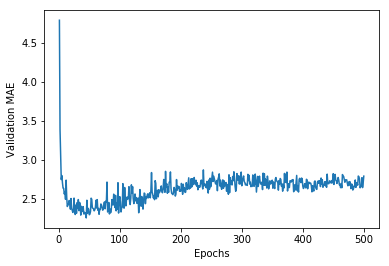

In [23]:
import matplotlib.pyplot as plt
plt.plot(range(1, len(average_mae_history) + 1), average_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

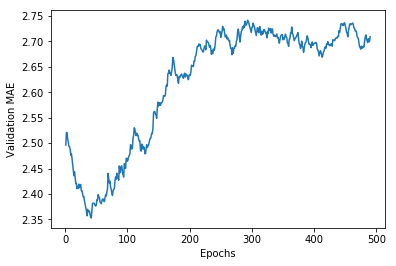

In [24]:
def smooth_curve(points, factor = 0.9):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points
smooth_mae_history = smooth_curve(average_mae_history[10:])
plt.plot(range(1, len(smooth_mae_history) + 1), smooth_mae_history)
plt.xlabel('Epochs')
plt.ylabel('Validation MAE')
plt.show()

In [25]:
# MAE stops imrpoving after 80 epochs
# Training Final Model
model = build_model()
model.fit(train_data, train_targets, epochs = 80, batch_size=16, verbose=0)
test_mse_score, test_mae_score = model.evaluate(test_data, test_targets)

102/102 [==============================] - 0s 492us/step


In [26]:
test_mae_score

2.678036998299991

# Overfitting in Machine Learning

Overfitting refers to a model that models the training data too well.

Overfitting happens when a model learns the detail and noise in the training data to the extent that it negatively impacts the performance of the model on new data. This means that the noise or random fluctuations in the training data is picked up and learned as concepts by the model. The problem is that these concepts do not apply to new data and negatively impact the models ability to generalize.

Overfitting is more likely with nonparametric and nonlinear models that have more flexibility when learning a target function. As such, many nonparametric machine learning algorithms also include parameters or techniques to limit and constrain how much detail the model learns.

For example, decision trees are a nonparametric machine learning algorithm that is very flexible and is subject to overfitting training data. This problem can be addressed by pruning a tree after it has learned in order to remove some of the detail it has picked up.

# Underfitting in Machine Learning

Underfitting refers to a model that can neither model the training data nor generalize to new data.

An underfit machine learning model is not a suitable model and will be obvious as it will have poor performance on the training data.

Underfitting is often not discussed as it is easy to detect given a good performance metric. The remedy is to move on and try alternate machine learning algorithms. Nevertheless, it does provide a good contrast to the problem of overfitting.

# A Good Fit in Machine Learning

Ideally, you want to select a model at the sweet spot between underfitting and overfitting.

This is the goal, but is very difficult to do in practice.

To understand this goal, we can look at the performance of a machine learning algorithm over time as it is learning a training data. We can plot both the skill on the training data and the skill on a test dataset we have held back from the training process.

Over time, as the algorithm learns, the error for the model on the training data goes down and so does the error on the test dataset. If we train for too long, the performance on the training dataset may continue to decrease because the model is overfitting and learning the irrelevant detail and noise in the training dataset. At the same time the error for the test set starts to rise again as the model’s ability to generalize decreases.

The sweet spot is the point just before the error on the test dataset starts to increase where the model has good skill on both the training dataset and the unseen test dataset.

You can perform this experiment with your favorite machine learning algorithms. This is often not useful technique in practice, because by choosing the stopping point for training using the skill on the test dataset it means that the testset is no longer “unseen” or a standalone objective measure. Some knowledge (a lot of useful knowledge) about that data has leaked into the training procedure.

There are two additional techniques you can use to help find the sweet spot in practice: resampling methods and a validation dataset.

# How To Limit Overfitting

Both overfitting and underfitting can lead to poor model performance. But by far the most common problem in applied machine learning is overfitting.

Overfitting is such a problem because the evaluation of machine learning algorithms on training data is different from the evaluation we actually care the most about, namely how well the algorithm performs on unseen data.

There are two important techniques that you can use when evaluating machine learning algorithms to limit overfitting:

1. Use a resampling technique to estimate model accuracy.
2. Hold back a validation dataset.

The most popular resampling technique is k-fold cross validation. It allows you to train and test your model k-times on different subsets of training data and build up an estimate of the performance of a machine learning model on unseen data.

A validation dataset is simply a subset of your training data that you hold back from your machine learning algorithms until the very end of your project. After you have selected and tuned your machine learning algorithms on your training dataset you can evaluate the learned models on the validation dataset to get a final objective idea of how the models might perform on unseen data.

Using cross validation is a gold standard in applied machine learning for estimating model accuracy on unseen data. If you have the data, using a validation dataset is also an excellent practice.